In [1]:
from typing import Tuple

import dgl
import torch 
from ogb.utils import smiles2graph
from ogb.lsc import DglPCQM4MDataset
import networkx as nx

import torch.nn as nn
import torch.nn.functional as F

Using backend: pytorch


In [2]:
dataset = DglPCQM4MDataset(root='/home/ksadowski/datasets', smiles2graph=smiles2graph)

In [3]:
dataset

DglPCQM4MDataset(3803453)

Num nodes: 7
Num edges: 19
Num source nodes: 7


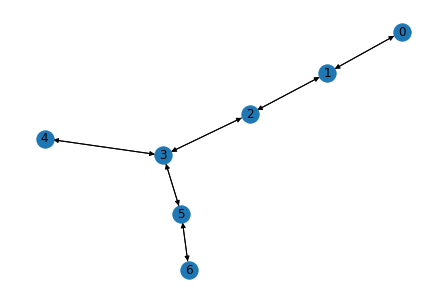

In [29]:
molecule = dgl.to_homogeneous(dataset[2736][0], ndata=dataset[2736][0].ndata, edata=dataset[2736][0].edata, store_type=False)
molecule = dgl.add_self_loop(molecule)
molecule_lg = dgl.line_graph(molecule, backtracking=False)

print(f'Num nodes: {molecule.num_nodes()}')
print(f'Num edges: {molecule.num_edges()}')
print(f'Num source nodes: {molecule.num_src_nodes()}')

nx.draw_kamada_kawai(molecule.to_networkx(), with_labels=True)

(tensor([ 0,  0,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  7,  7,  7,  8,  8,
         9,  9,  9, 10, 11, 11, 12, 13, 13, 14, 14, 15, 15, 15, 16, 17, 17, 18]), tensor([ 2, 13, 12,  4, 14,  1, 13,  6,  8, 15,  3, 14, 16,  5,  8, 15, 10, 17,
         5,  6, 15, 18,  9, 17,  0,  1,  2,  3,  4,  5,  6,  8,  7,  9, 10, 11]))
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0.],
        [0

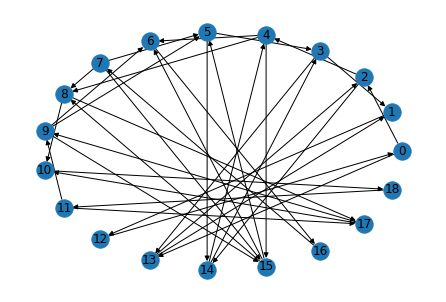

In [30]:
print(molecule_lg.edges())
print(molecule_lg.adjacency_matrix().to_dense())

nx.draw_circular(molecule_lg.to_networkx(), with_labels=True)

In [31]:
class SelfAttention(nn.Module):
    def __init__(self, in_feats):
        super().__init__()
        self.key_linear = nn.Linear(in_feats, 1)
        self.value_linear = nn.Linear(in_feats, in_feats)

    def forward(self, inputs):
        key = self.key_linear(inputs)
        value = self.value_linear(inputs)

        x = value @ inputs.t() @ key
        x = F.softmax(x, dim=0)

        return x

class AttentionGraphConv(nn.Module):
    def __init__(self, in_feats, aggregation_function: str):
        super().__init__()
        self.aggregation_function = aggregation_function
        self.linear = nn.Linear(in_feats, in_feats)

    def forward(self, inputs: torch.Tensor(), attention_adjacency: torch.Tensor()):
        if self.aggregation_function == 'sum':
            x = attention_adjacency @ inputs
        elif self.aggregation_function == 'mean':
            degree = torch.diag(torch.count_nonzero(attention_adjacency, dim=1))
            degree_inverse = torch.linalg.inv(degree.float())

            x = degree_inverse @ attention_adjacency @ inputs

        x = self.linear(x)

        return x


class Head(nn.Module):
    def __init__(self, node_in_feats: int, edge_in_feats: int, num_cycles: int) -> None:
        super().__init__()
        self.num_cycles = num_cycles
        self.node_attention = SelfAttention(node_in_feats)
        self.node_query_linear = nn.Linear(node_in_feats, node_in_feats)
        self.node_query_conv = AttentionGraphConv(node_in_feats, 'mean')
        self.edge_attention = SelfAttention(edge_in_feats)
        self.edge_query_linear = nn.Linear(edge_in_feats, edge_in_feats)
        self.edge_query_conv = AttentionGraphConv(edge_in_feats, 'sum')

    def create_mutual_node_attention_adjacency(self, g: dgl.DGLGraph, edge_attention: torch.Tensor) -> torch.Tensor:
        node_adjacency = g.adj().to_dense()

        for edge in range(g.num_edges()):
            nodes = g.find_edges(edge)

            source_node = nodes[0].item()
            destination_node = nodes[1].item()

            node_adjacency[source_node][destination_node] = edge_attention[edge]

        return node_adjacency


    def create_mutual_edge_attention_adjacency(self, g: dgl.DGLGraph, lg: dgl.DGLGraph, node_attention: torch.Tensor) -> torch.Tensor:
        edge_adjacency = lg.adj().to_dense()

        for node in range(lg.num_edges()):
            edges = lg.find_edges(node)

            source_edge = edges[0].item()
            destination_edge = edges[1].item()

            connecting_node = g.find_edges(source_edge)[1]
            
            edge_adjacency[source_edge][destination_edge] = node_attention[connecting_node]

        return edge_adjacency


    def forward(
        self, 
        g: dgl.DGLGraph, 
        lg: dgl.DGLGraph, 
        node_feats: torch.Tensor, 
        edge_feats: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        node_embeddings = node_feats
        edge_embeddings = edge_feats

        for _ in range(self.num_cycles):
            node_attention = self.node_attention(node_embeddings)
            edge_attention = self.edge_attention(edge_embeddings)
            
            node_mutual_attention_adjacency = self.create_mutual_node_attention_adjacency(g, edge_attention)
            node_query = self.node_query_linear(node_embeddings)
            node_embeddings = self.node_query_conv(node_query, node_mutual_attention_adjacency)

            edge_mutual_attention_adjacency = self.create_mutual_edge_attention_adjacency(g, lg, node_attention)
            edge_query = self.edge_query_linear(edge_embeddings)
            edge_embeddings = self.edge_query_conv(edge_query, edge_mutual_attention_adjacency)
        
        return node_embeddings, edge_embeddings

node_feats = molecule.ndata['feat'].float()
edge_feats = molecule.edata['feat'].float()

node_out, edge_out = Head(9, 3, 2)(molecule, molecule_lg, node_feats, edge_feats)

print(node_out, edge_out)


tensor([[-0.1830, -0.2054, -0.0712, -0.2105,  0.3456,  0.0190,  0.1117,  0.0676,
          0.1333],
        [-0.1870, -0.1997, -0.0620, -0.2043,  0.3373,  0.0242,  0.1032,  0.0872,
          0.1351],
        [-0.1901, -0.1955, -0.0552, -0.1998,  0.3312,  0.0279,  0.0970,  0.1014,
          0.1364],
        [-0.1901, -0.1955, -0.0552, -0.1999,  0.3312,  0.0279,  0.0970,  0.1015,
          0.1364],
        [-0.1902, -0.1955, -0.0552, -0.1999,  0.3312,  0.0279,  0.0970,  0.1014,
          0.1364],
        [-0.1901, -0.1956, -0.0551, -0.2000,  0.3313,  0.0279,  0.0970,  0.1015,
          0.1365],
        [-0.1901, -0.1956, -0.0551, -0.2000,  0.3314,  0.0278,  0.0971,  0.1016,
          0.1365]], grad_fn=<AddmmBackward>) tensor([[-0.5606, -0.3001,  0.2408],
        [-0.5447, -0.3007,  0.2607],
        [-0.5606, -0.3001,  0.2408],
        [-0.5600, -0.2986,  0.2509],
        [-0.5770, -0.2980,  0.2283],
        [-0.5606, -0.3001,  0.2408],
        [-0.5443, -0.3021,  0.2533],
        [-0.577

In [60]:
class GraphMutualAttentionTransformer(nn.Module):
    def __init__(
        self, 
        node_in_feats: int, 
        edge_in_feats: int, 
        num_heads: int, 
        num_cycles: int,
    ) -> None:
        super().__init__()
        self.num_heads = num_heads
        self.num_cycles = num_cycles
        self.heads = nn.ModuleList([Head(node_in_feats, edge_in_feats, num_cycles) for _ in range(num_heads)])
        self.node_embeddings_linear = nn.Linear(node_in_feats * num_heads, 1)
        self.edge_embeddings_linear = nn.Linear(edge_in_feats * num_heads, 1)

    def forward(
        self, 
        g: dgl.DGLGraph, 
        lg: dgl.DGLGraph, 
        node_feats: torch.Tensor, 
        edge_feats: torch.Tensor,
    ) -> float:
        node_embeddings = []
        edge_embeddings = []

        for i, head in enumerate(self.heads):
            node_embedding, edge_embedding = head(g, lg, node_feats, edge_feats)

            node_embeddings.append(node_embedding)
            edge_embeddings.append(edge_embedding)

        

        node_embeddings = torch.cat(node_embeddings, dim=1)
        node_embeddings = torch.mean(node_embeddings, dim=0)
        node_embeddings = self.node_embeddings_linear(node_embeddings)

        edge_embeddings = torch.cat(edge_embeddings, dim=1)
        edge_embeddings = torch.mean(edge_embeddings, dim=0)
        edge_embeddings = self.edge_embeddings_linear(edge_embeddings)

        return node_embeddings, edge_embeddings

node_feats = molecule.ndata['feat'].float()
edge_feats = molecule.edata['feat'].float()

model = GraphMutualAttentionTransformer(9, 3, 16, 2)

node_embeddings, edge_embeddings = model(molecule, molecule_lg, node_feats, edge_feats)

print(edge_embeddings, node_embeddings)


tensor([0.2519], grad_fn=<AddBackward0>) tensor([0.0110], grad_fn=<AddBackward0>)


In [56]:
x = torch.mean(edge_embeddings, dim=0)
x = nn.Linear(12, 1)(x)

x

tensor([0.0478], grad_fn=<AddBackward0>)